In [108]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import json
import os
from sklearn.preprocessing import StandardScaler
import numpy as np

In [109]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [110]:
# Load JSON data from a file
cwd = os.getcwd() # Set current working directory
preset_data = [] #add read size
with open(os.path.join(cwd, 'data.json'), 'r') as f:
    for line in f:
        preset_data.append(json.loads(line))

class item_based_dataset(Dataset):
    def __init__(self, preset_data):
        self.preset_data = preset_data

    def __getitem__(self, index):
        try:
            asin = self.preset_data[index]['asin']
            price_mean = float(self.preset_data[index]['price'][0].split('.')[0]) if self.preset_data[index]['price'][0] else -1
            price_diff = float(self.preset_data[index]['price'][1].split('.')[0]) if self.preset_data[index]['price'][1] else -1
            avg_rating = float(self.preset_data[index]['avg_rating']) if self.preset_data[index]['avg_rating'] else -1
            rank = float(self.preset_data[index]['rank']) if self.preset_data[index]['rank'] else -1
            brand = float(self.preset_data[index]['brand']) if self.preset_data[index]['brand'] else -1
            category = self.preset_data[index]['category'] or [-1, -1]
            category_a, category_b = (category + [-1, -1])[:2]
            activeness = float(self.preset_data[index]['activeness']) if self.preset_data[index]['activeness'] else -1
            packed_data = [price_mean, price_diff, rank, brand, category_a, category_b, activeness]
            trainset = torch.tensor(packed_data)  # convert to tensor
            Verify_ans = torch.tensor([avg_rating], dtype=torch.float)
            return trainset, Verify_ans
        except KeyError as e:
            print(f"KeyError: {e} is not found in the data at index {index}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def __len__(self):
        return len(self.preset_data)

In [111]:
# Define hyperparameters
input_size = 7  # Dimension of input features
hidden_size = 128  # Number of neurons in the hidden layer
output_size = 1  # Dimension of output (predicted rating)

In [112]:
# Instantiate the model
model = MLP(input_size, hidden_size, output_size)

In [113]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [114]:
# Instantiate the dataset and dataloader
dataset = item_based_dataset(preset_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [115]:

import json
from torch.utils.data import DataLoader

# Initialize an empty list to store the data
data = []

# Open the JSON file and read each line
with open('data.json', 'r') as f:
    for line in f:
        # Load the JSON object from the current line
        json_data = json.loads(line)
        # Append the JSON object to the data list
        data.append(json_data)

# Define the batch size for the DataLoader
batch_size = 32  # You can adjust this value as needed
# Define your dataset
dataset = item_based_dataset(data)

# Define a DataLoader object for the dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Split the data into training and validation sets
train_size = int(0.8 * len(data))  # 80% for training
val_size = len(data) - train_size   # Remaining for validation
train_data, val_data = random_split(data, [train_size, val_size])

# Define your training and validation datasets
train_dataset = item_based_dataset(train_data)
val_dataset = item_based_dataset(val_data)

# Define DataLoader objects for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [117]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Instantiate the model, criterion, optimizer, dataset, and dataloader
# (Assuming you have already done this)

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

num_epochs = 100
prev_loss = float('inf')  # Set initial previous loss to infinity
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    for inputs, targets in train_dataloader:  # Assuming you have separate dataloaders for training and testing
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)  # Multiply by batch size

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_dataset)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:  # Assuming you have separate dataloaders for training and testing
            outputs = model(inputs.float())
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)  # Multiply by batch size

    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_dataset)

    # Calculate percentage change in loss
    percentage_change = (prev_loss - epoch_val_loss) / prev_loss * 100 if prev_loss != float('inf') else None

    # Print both training and validation losses
    if percentage_change is not None:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Loss Percentage Change: {percentage_change:.2f}%')
    else:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Update previous loss for the next epoch
    prev_loss = epoch_val_loss

    # Append losses to lists for plotting
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # Check for NaN loss and adjust learning rate if necessary
    if epoch_val_loss != epoch_val_loss:  # Check for NaN loss
        print("NaN loss detected in validation. Adjusting learning rate.")
        scheduler.step(epoch_val_loss)  # Adjust learning rate
    else:
        scheduler.step(epoch_val_loss)  # Update learning rate based on validation loss



Epoch [1/100], Train Loss: 2387256.5033, Val Loss: 953.2905
Epoch [2/100], Train Loss: 150108.4603, Val Loss: 40.9720, Loss Percentage Change: 95.70%
Epoch [3/100], Train Loss: 690449.9188, Val Loss: 214.0325, Loss Percentage Change: -422.39%
Epoch [4/100], Train Loss: 321994.6893, Val Loss: 57.1670, Loss Percentage Change: 73.29%
Epoch [5/100], Train Loss: 508404.5733, Val Loss: 22.3288, Loss Percentage Change: 60.94%
Epoch [6/100], Train Loss: 312393.1508, Val Loss: 166624.2781, Loss Percentage Change: -746132.00%
Epoch [7/100], Train Loss: 130965.4293, Val Loss: 1499.9051, Loss Percentage Change: 99.10%
Epoch [8/100], Train Loss: 458294.5719, Val Loss: 5056.1947, Loss Percentage Change: -237.10%
Epoch [9/100], Train Loss: 93946.1243, Val Loss: 102.6575, Loss Percentage Change: 97.97%
Epoch [10/100], Train Loss: 37525.8551, Val Loss: 481.3644, Loss Percentage Change: -368.90%
Epoch [11/100], Train Loss: 131839.7544, Val Loss: 55.3510, Loss Percentage Change: 88.50%
Epoch [12/100], Tr

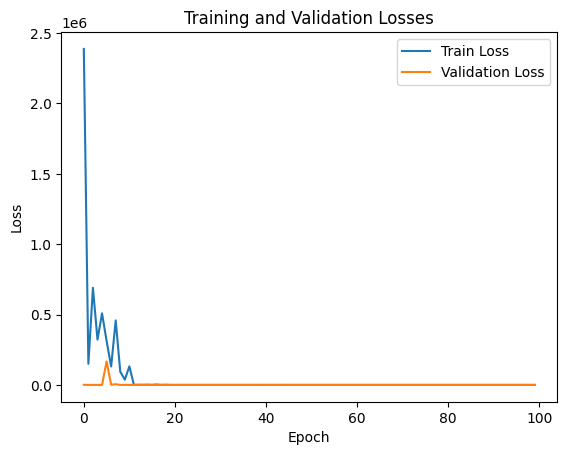

In [118]:

# Plotting the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()